# Вероятность сердечно-сосудистых заболеваний

## Оглавление
1. [Открытие и изучение файла](#paragraph1)    
2. [Предобработка данных](#paragraph2)  
    2.1 [Преобразование данных](#subparagraph1)  
    2.2 [Обработка дубликатов](#subparagraph2)  
    2.3 [Обработка аномальных значений](#subparagraph3)  
3. [Исследовательский анализ данных](#paragraph3)  
4. [Разработка моделей](#paragraph4)  
    4.1 [Подготовка признаков](#subparagraph4)  
    4.2 [Обучение моделей](#subparagraph5)  
5. [Улучшение модели](#paragraph5)  
    5.1 [Важность признаков](#subparagraph6)  
    5.2 [Подбор параметров модели](#subparagraph7)
6. [Предсказание вероятностей](#paragraph6)  
    6.1 [Калибровка вероятностей](#subparagraph8)  
    6.2 [Сохранение результата](#subparagraph9)  

In [143]:
!pip install phik

<a name="paragraph1"></a>

## Открытие и изучение файла

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

**Загрузим информацию о тренировочном датасете:**

In [91]:
df = pd.read_csv('D:/DS+/Kaggle/train.csv')

In [92]:
def info_df(df):
    print('Общая информация:')
    display(df.info())
    print('Данные:')
    display(df.head())
    print('Описательные статистики:')
    display(df.describe())
    print('Частотное распределение данных:')
    df.hist(figsize=(16,14))
    plt.show()
    return

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


None

Данные:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Описательные статистики:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Частотное распределение данных:


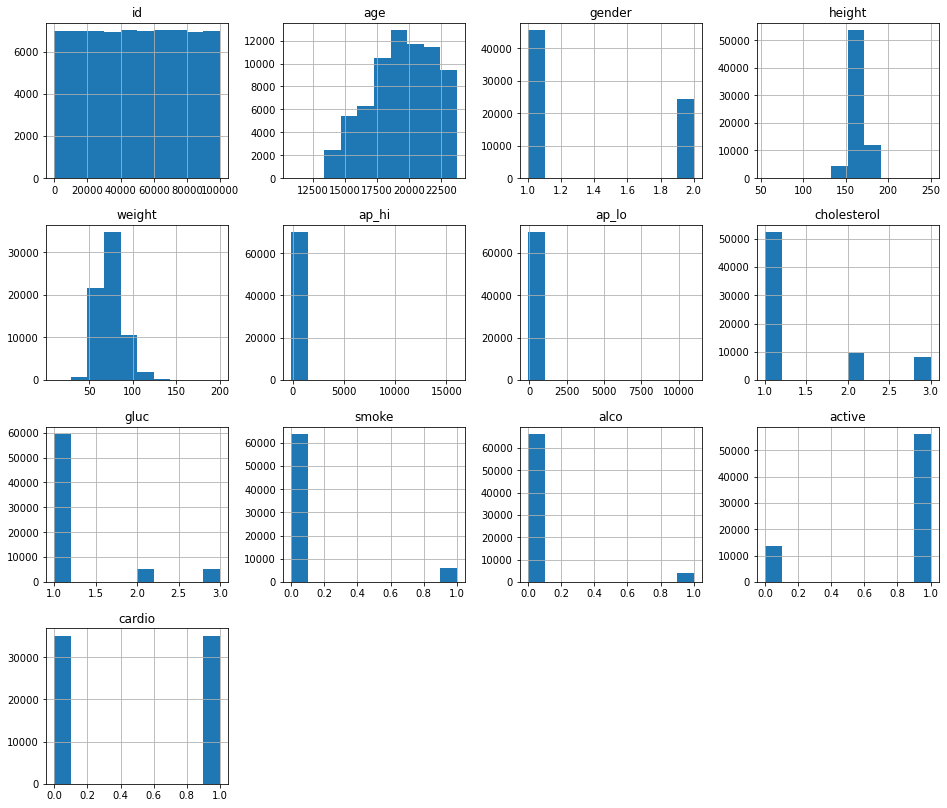

In [93]:
info_df(df)

**Проверим корреляцию признаков:**

In [94]:
def phik(df):
    phik_overview = df.phik_matrix()
    plot_correlation_matrix(phik_overview.values, 
                            x_labels=phik_overview.columns, 
                            y_labels=phik_overview.index, 
                            vmin=0, vmax=1, color_map="Greens", 
                            title='Матрица корреляции Phik', 
                            fontsize_factor=1.4, 
                            figsize=(18, 18))
    plt.tight_layout()
    return

interval columns not set, guessing: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


D:\Programm Files\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


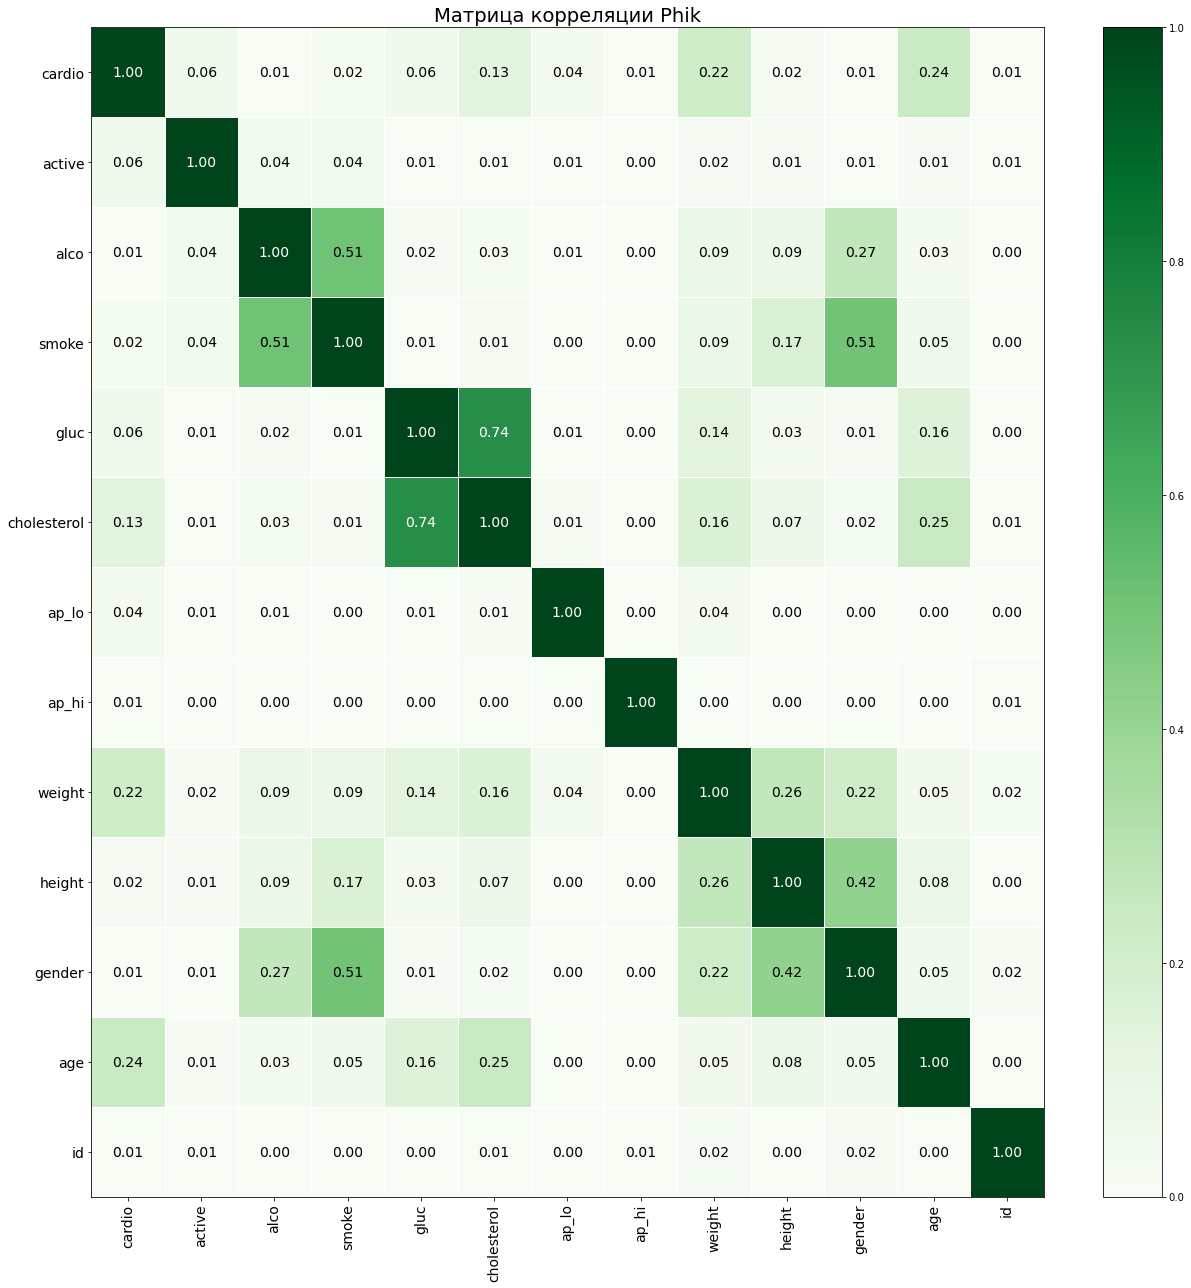

In [95]:
phik(df)

Наиболее коррелируемые призанки с целевым:  
age, weight, cholesterol

gluc, height, gender

**Загрузим тестовый датасет:**

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


None

Данные:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


Описательные статистики:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000
mean,50062.686900,19455.528400,1.353733,164.322267,74.120615,130.271300,95.689000,1.368033,1.222700,0.08860,0.055000,0.805733
std,28906.167148,2477.840922,0.478136,8.213740,14.341540,212.501152,163.852598,0.679166,0.566494,0.28417,0.227984,0.395642
min,5.000000,8865.000000,1.000000,50.000000,10.000000,-130.000000,-90.000000,1.000000,1.000000,0.00000,0.000000,0.000000
25%,24983.250000,17658.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.00000,0.000000,1.000000
50%,49995.500000,19694.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.00000,0.000000,1.000000
75%,75232.250000,21320.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.00000,0.000000,1.000000
max,99997.000000,23705.000000,2.000000,198.000000,183.000000,16020.000000,9100.000000,3.000000,3.000000,1.00000,1.000000,1.000000


Частотное распределение данных:


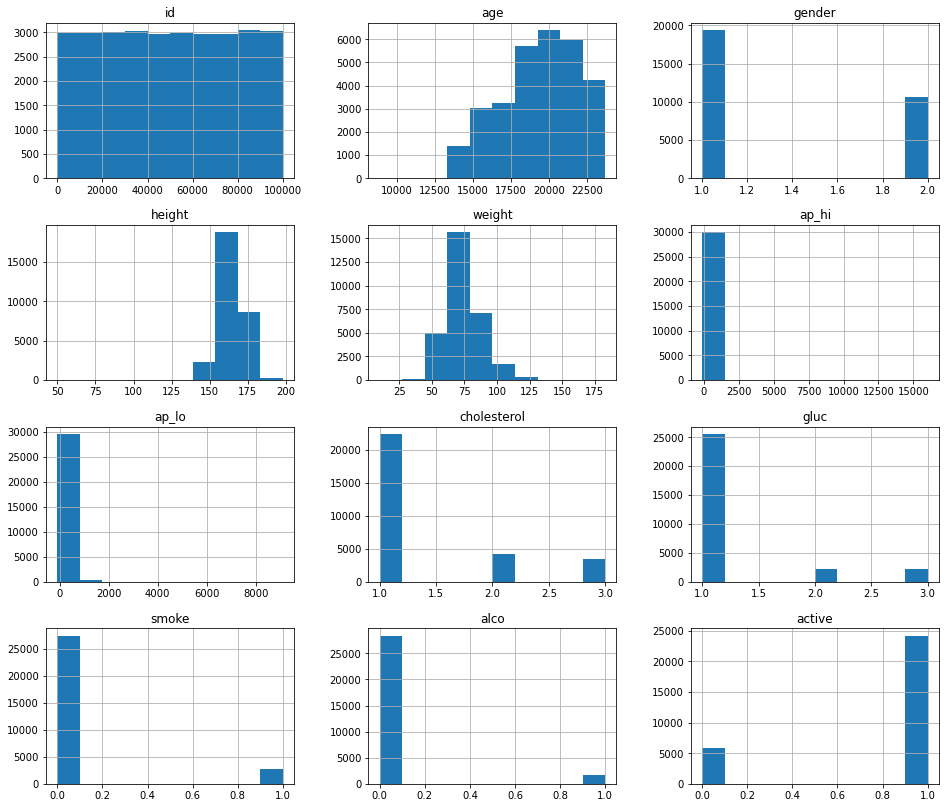

In [96]:
df_test = pd.read_csv('D:/DS+/Kaggle/test.csv')
info_df(df_test)

**Выводы:**  
- признак 'age' указан в днях;  
- выбросы в данных по признакам 'ap_hi', 'ap_lo';
- пропуски в данных отсутствуют;  
- присутствует корреляция незавсимых признаков с целевым cardio: age, weight, cholesterol;  
- баланс классов по целевому признаку.  

<a name="paragraph2"></a>

## 2 Предобработка данных

<a name="subparagraph1"></a>

### 2.1 Преобразование данных

**height:**

In [97]:
df['height'].unique()

array([168, 156, 165, 169, 151, 157, 178, 158, 164, 173, 181, 172, 170,
       154, 162, 163, 153, 159, 166, 155, 160, 175, 171, 152, 187, 148,
       179, 180, 188, 185, 167, 183, 174, 176, 161, 184, 177, 182,  76,
       149, 142, 150, 144, 147, 186, 146, 141, 195, 140, 198, 145, 143,
       196, 138, 194, 190, 134, 136, 100, 120, 189, 137, 192, 122, 250,
       191, 117,  70,  97, 119, 130, 110, 193,  75, 132,  71, 135,  67,
       125, 139, 133,  74,  98, 112, 207,  68,  55,  81,  80,  64,  91,
        60, 109,  72, 197,  65, 128, 105, 108, 200, 104, 111, 113,  96,
       131,  59,  66,  99,  57], dtype=int64)

In [98]:
df[df['height'] < 100]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
224,309,21800,2,76,55.0,120,80,1,1,0,0,1,0
7598,10843,14661,2,70,72.0,120,8,1,1,0,0,1,0
8171,11662,17646,2,97,170.0,160,100,1,1,1,0,1,1
12770,18218,19594,1,75,168.0,120,80,1,1,1,0,1,1
13265,18928,22456,2,71,68.0,120,80,3,1,0,0,1,0
14323,20459,22005,1,67,57.0,120,90,1,1,0,0,1,1
15167,21686,15812,1,70,68.0,120,80,1,1,0,0,0,0
16699,23859,19680,2,74,98.0,140,90,1,1,0,0,1,1
17277,24690,17530,1,98,45.0,12,80,1,1,0,0,1,0
22542,32207,14538,1,68,65.0,100,60,1,1,0,0,0,0


Предположим, что пропущена 1:

In [99]:
df.loc[df['height'] < 100, ['height']] =  + 100
df['height'].unique()

array([168, 156, 165, 169, 151, 157, 178, 158, 164, 173, 181, 172, 170,
       154, 162, 163, 153, 159, 166, 155, 160, 175, 171, 152, 187, 148,
       179, 180, 188, 185, 167, 183, 174, 176, 161, 184, 177, 182, 100,
       149, 142, 150, 144, 147, 186, 146, 141, 195, 140, 198, 145, 143,
       196, 138, 194, 190, 134, 136, 120, 189, 137, 192, 122, 250, 191,
       117, 119, 130, 110, 193, 132, 135, 125, 139, 133, 112, 207, 109,
       197, 128, 105, 108, 200, 104, 111, 113, 131], dtype=int64)

Проведем преобразования на тестовой выборке:

In [100]:
df_test['height'].unique()

array([154, 170, 160, 185, 164, 162, 168, 150, 167, 163, 180, 173, 156,
       155, 165, 159, 182, 174, 169, 176, 172, 157, 171, 166, 161, 153,
       190, 175, 177, 152, 187, 158, 149, 147, 178, 179, 151, 181, 184,
       110, 145, 183, 148, 191, 186, 189,  58, 116, 140, 130, 146,  65,
       138, 143, 142, 141, 144, 194, 188, 139, 100, 198, 120, 192, 136,
        68,  72, 195, 114, 122, 197,  50,  62, 193,  60, 196, 105,  87,
       119,  52, 127, 131, 134, 135,  56, 137, 102], dtype=int64)

In [101]:
df_test.loc[df_test['height'] < 100, ['height']] =  + 100
df_test['height'].unique()

array([154, 170, 160, 185, 164, 162, 168, 150, 167, 163, 180, 173, 156,
       155, 165, 159, 182, 174, 169, 176, 172, 157, 171, 166, 161, 153,
       190, 175, 177, 152, 187, 158, 149, 147, 178, 179, 151, 181, 184,
       110, 145, 183, 148, 191, 186, 189, 100, 116, 140, 130, 146, 138,
       143, 142, 141, 144, 194, 188, 139, 198, 120, 192, 136, 195, 114,
       122, 197, 193, 196, 105, 119, 127, 131, 134, 135, 137, 102],
      dtype=int64)

**age:**

In [102]:
df['age'] = (round(df['age'] / 365)).astype('int16')
df['age'].unique()

array([50, 55, 52, 48, 60, 61, 62, 54, 41, 40, 46, 58, 59, 63, 64, 57, 56,
       49, 51, 44, 65, 45, 53, 47, 42, 39, 43, 30], dtype=int16)

Проведем преобразования на тестовой выборке:

In [103]:
df_test['age'] = (round(df_test['age'] / 365)).astype('int16')
df_test['age'].unique()

array([52, 56, 50, 44, 46, 43, 60, 48, 64, 49, 62, 40, 54, 58, 57, 51, 59,
       63, 53, 61, 39, 42, 65, 55, 45, 41, 47, 24, 25, 29, 30],
      dtype=int16)

<a name="subparagraph2"></a>

### 2.2 Обработка дубликатов

In [104]:
df.duplicated().sum()

0

**Вывод:** дубликаты отсутствуют.

<a name="subparagraph3"></a>

### 2.3 Обработка аномальных значений

Аномальные значения присутствуют в признаках `ap_hi` и `ap_lo`. Для обработки аномальных значений создадим две функции:  
- `anomaly_handling_hi` для преобразования признака ap_hi;  
- `anomaly_handling_lo` для преобразования признака ap_lo;  
Преобразования проведем на тестовой и тренировочной выборках.

**ap_hi:**

In [105]:
def anomaly_handling_hi(df, feature):
    print('Распределение признака', feature, 'до обработки')
    sns.boxplot(y=df[feature])
    plt.show()
    df.loc[df[feature] > 10000, [feature]] = (df.loc[df[feature] > 10000, [feature]]) / 100
    df.loc[df[feature] > 300, [feature]] = (df.loc[df[feature] > 300, [feature]]) / 10
    df.loc[df[feature] < 0, [feature]] = abs(df.loc[df[feature] < 0, [feature]])
    df.loc[df[feature] < 25, [feature]] =  (df.loc[df[feature] < 25, [feature]]) * 10
    print('Распределение признака', feature, 'после обработки')
    sns.boxplot(y=df[feature])
    plt.show()
    return
    

In [106]:
def anomaly_handling_lo(df, feature):
    print('Распределение признака ap_lo до обработки')
    sns.boxplot(y=df[feature])
    plt.show()
    df.loc[df[feature] > 3000, [feature]] = (df.loc[df[feature] > 3000, [feature]]) / 100
    df.loc[df[feature] > 500, [feature]] = (df.loc[df[feature] > 500, [feature]]) / 10
    df.loc[df[feature] < 0, [feature]] = abs(df.loc[df[feature] < 0, [feature]])
    df.loc[df[feature] < 25, [feature]] =  (df.loc[df[feature] < 25, [feature]]) * 10
    print('Распределение признака ap_lo после обработки')
    sns.boxplot(y=df[feature])
    plt.show()
    return

**Тренировочная выборка:**

Распределение признака ap_hi до обработки


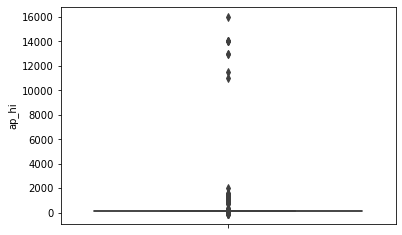

Распределение признака ap_hi после обработки


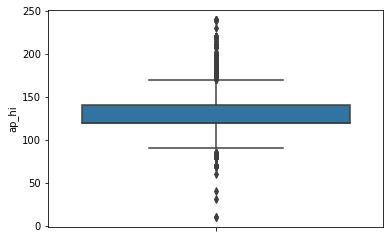

In [107]:
anomaly_handling_hi(df, 'ap_hi')

**ap_lo:**

Распределение признака ap_lo до обработки


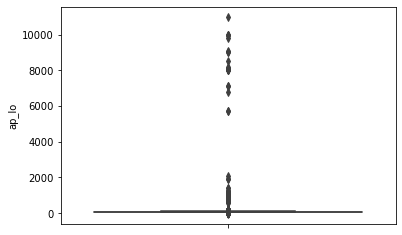

Распределение признака ap_lo после обработки


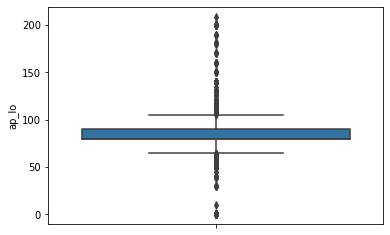

In [108]:
anomaly_handling_lo(df, 'ap_lo')

Проверим данные по условию, что верхнее давление меньше нижнего:

In [109]:
df[df['ap_hi'] < df['ap_lo']]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
474,681,52,1,156,65.0,120.0,150.0,2,1,0,0,1,0
636,913,56,2,169,68.0,70.0,110.0,1,1,0,0,1,0
2384,3356,64,1,154,102.0,90.0,150.0,1,1,0,0,0,1
2990,4214,60,2,182,90.0,80.0,140.0,3,3,0,0,1,1
3447,4880,55,2,180,80.0,80.0,125.0,3,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66657,95164,53,2,160,81.0,80.0,120.0,3,3,1,1,1,1
67421,96271,64,1,153,74.0,80.0,130.0,1,1,0,0,1,1
67470,96339,58,2,172,57.0,80.0,120.0,1,1,1,0,1,1
68067,97210,50,1,152,65.0,80.0,120.0,1,1,0,0,1,0


In [110]:
df[['ap_hi', 'ap_lo']] = df[['ap_lo', 'ap_hi']].where(df['ap_hi'] < df['ap_lo'],
                                                      df[['ap_hi', 'ap_lo']].values)

In [111]:
df[df['ap_hi'] < df['ap_lo']]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


In [112]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.338686,1.349571,164.370329,74.205690,127.082970,81.567908,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,6.765294,0.476838,8.100561,14.395757,17.090583,9.895574,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,30.000000,1.000000,100.000000,10.000000,30.900000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,65.000000,2.000000,250.000000,200.000000,240.000000,200.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Ограничим выборку по условиям:

In [113]:
df = df.loc[df['ap_hi'] >= 60]
df = df.loc[df['ap_lo'] >= 40]
df = df.loc[df['weight'] >= 30]

**Тестовая выборка:**

**ap_hi**

Распределение признака ap_hi до обработки


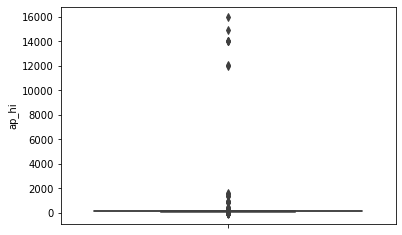

Распределение признака ap_hi после обработки


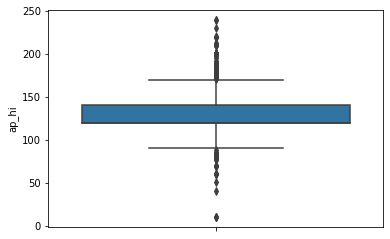

In [114]:
anomaly_handling_hi(df_test, 'ap_hi')

**ap_lo**

Распределение признака ap_lo до обработки


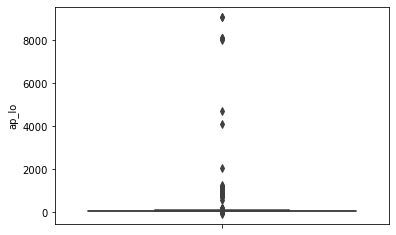

Распределение признака ap_lo после обработки


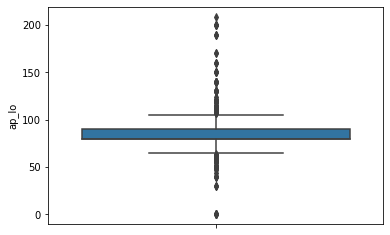

In [115]:
anomaly_handling_lo(df_test, 'ap_lo')

Проверим данные по условию, что верхнее давление меньше нижнего:

In [116]:
df_test[df_test['ap_hi'] < df_test['ap_lo']].head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
303,1079,62,2,170,74.0,40.0,60.0,1,1,0,0,1
605,2080,58,2,168,73.0,90.0,130.0,1,1,0,0,0
1097,3777,45,1,169,87.0,90.0,160.0,1,1,0,0,1
1112,3825,55,1,159,71.0,80.0,130.0,1,1,0,0,1
1261,4345,58,1,156,87.0,90.0,150.0,3,3,0,0,1


In [117]:
df_test[['ap_hi', 'ap_lo']] = df_test[['ap_lo', 'ap_hi']].where(df_test['ap_hi'] < df_test['ap_lo'],
                                                      df_test[['ap_hi', 'ap_lo']].values)

In [118]:
df_test[df_test['ap_hi'] < df_test['ap_lo']]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active


In [119]:
df_test.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000
mean,50062.686900,53.305467,1.353733,164.337367,74.120615,127.105126,81.604954,1.368033,1.222700,0.08860,0.055000,0.805733
std,28906.167148,6.794338,0.478136,8.056884,14.341540,17.006357,9.794624,0.679166,0.566494,0.28417,0.227984,0.395642
min,5.000000,24.000000,1.000000,100.000000,10.000000,30.000000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000
25%,24983.250000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.00000,0.000000,1.000000
50%,49995.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.00000,0.000000,1.000000
75%,75232.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.00000,0.000000,1.000000
max,99997.000000,65.000000,2.000000,198.000000,183.000000,240.000000,172.000000,3.000000,3.000000,1.00000,1.000000,1.000000


<a name="paragraph3"></a>

## 3. Исследовательский анализ данных

После преобразования данных повторно проверим корреляцию признаков:

interval columns not set, guessing: ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


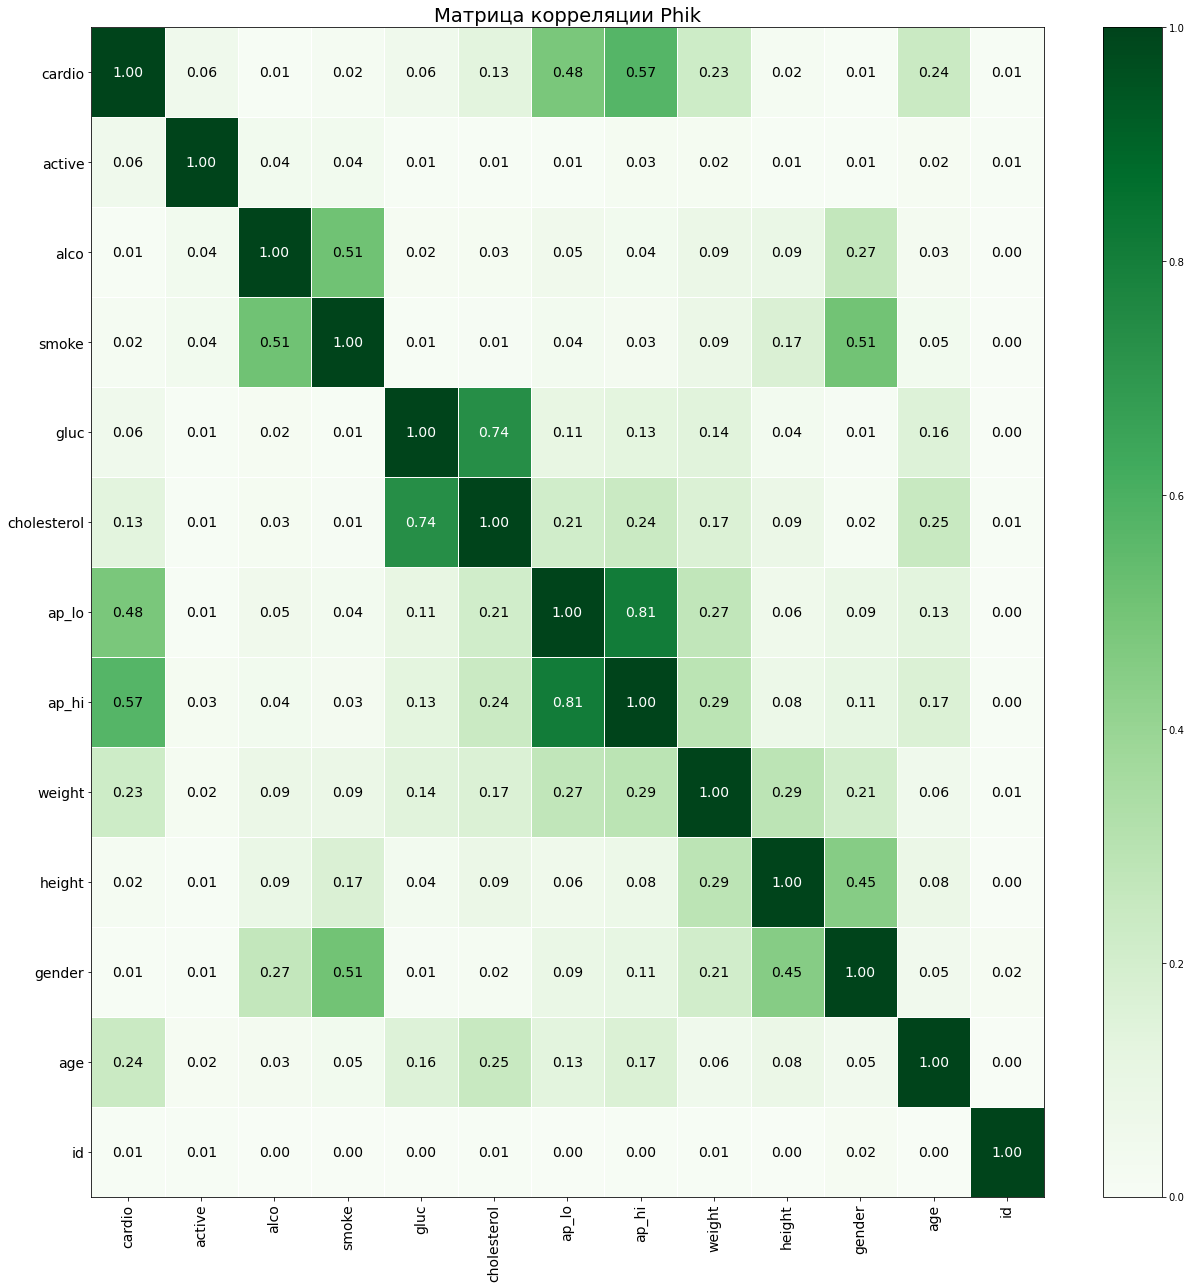

In [120]:
phik(df)

Рассмотрим распределение данных по наиболее коррелируемым признакам:

- age  
- weight  
- cholesterol  
- gluc  
- height  
- gender  
- ap_hi
- ap_lo

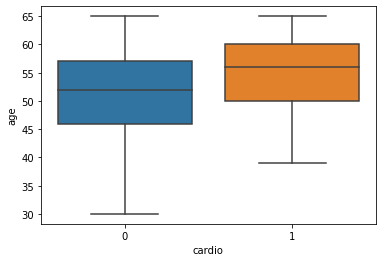

In [123]:
sns.boxplot(x=df['cardio'], y=df['age'])
plt.show()

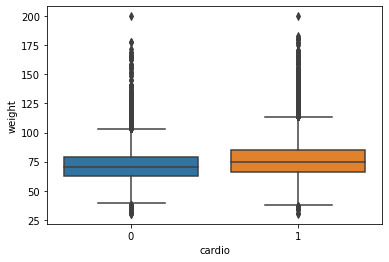

In [124]:
sns.boxplot(x=df['cardio'], y=df['weight'])
plt.show()

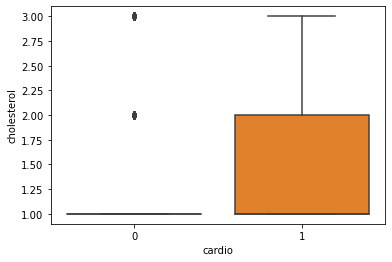

In [126]:
sns.boxplot(x=df['cardio'], y=df['cholesterol'])
plt.show()

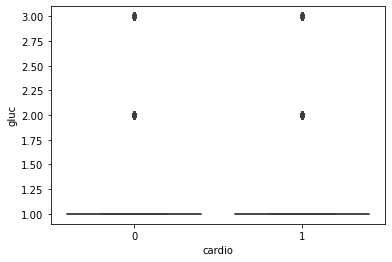

In [127]:
sns.boxplot(x=df['cardio'], y=df['gluc'])
plt.show()

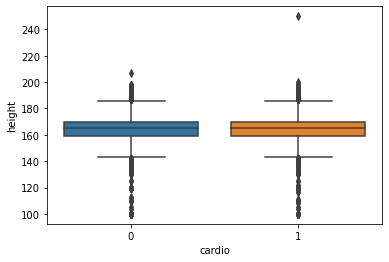

In [128]:
sns.boxplot(x=df['cardio'], y=df['height'])
plt.show()

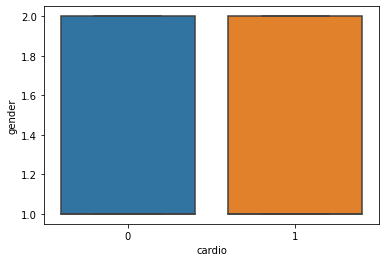

In [129]:
sns.boxplot(x=df['cardio'], y=df['gender'])
plt.show()

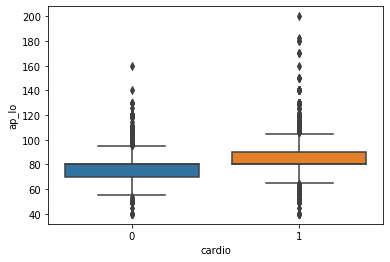

In [130]:
sns.boxplot(x=df['cardio'], y=df['ap_lo'])
plt.show()

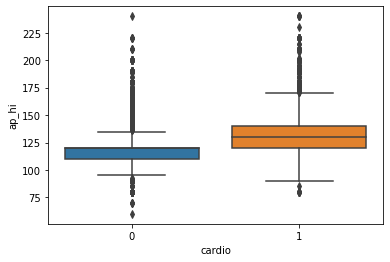

In [131]:
sns.boxplot(x=df['cardio'], y=df['ap_hi'])
plt.show()

**Вывод:**  
Наиболее явно сердечно-сосудисые заболевания наблюдаются по следующим признакам:  
 - `age`. От 50 до 60 лет;  
 - `cholesterol`. При значении признака  - 2;  
 - `weight`. При весе от 70 до 80 кг;  
 - `ap_lo`. При значении нижнего давления от 80 до 90;  
 - `ap_hi`. При значении верхнего давления 120 до 140.  
 Признаки `height`, `gluc`, `height`, `gender` значимого влияния не имеют.

<a name="paragraph4"></a>

## 4. Разработка моделей

Построим модели по двум алгоритмам: случайный лес и логистическая регрессия. В качестве метрики использем ROC-AUC.

<a name="subparagraph4"></a>

### 4.1 Подготовка признаков

Исходные данные содержат 12 признаков. 11 независимых и целевой `cardio`. По результатам исследовательского анализа наиболее значимые признаки: ap_hi, ap_lo, age, weight, cholesterol. Признак id является уникальным идентификатором наблюдения, не влияющим на целевой признак. Признаки ap_hi и ap_lo значительно коррелируют между собой, но используем их для предварительного построения моделей.  


In [167]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [184]:
X_train = df[['age', 'ap_hi', 'ap_lo', 'weight', 'cholesterol']]
y_train = df['cardio']
X_train.shape

(69963, 5)

In [185]:
X_test = df_test[['age', 'ap_hi', 'ap_lo', 'weight', 'cholesterol']]
X_test.shape

(30000, 5)

In [186]:
RANDOM_STATE = 25

In [187]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3,\
                                                                              stratify=y_train, random_state=RANDOM_STATE)

<a name="subparagraph5"></a>

### 4.2 Обучение моделей

#### Случайный лес

In [188]:
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=50, criterion='entropy', max_depth=12,\
                                          min_samples_leaf=2)
pipeline_rfc = make_pipeline(StandardScaler(), model_rfc)
pipeline_rfc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=12,
                                        min_samples_leaf=2, n_estimators=50,
                                        random_state=25))])

In [189]:
scoring_rfc = cross_val_score(pipeline_rfc, X_train, y_train, cv=5, scoring='roc_auc')
roc_auc_rfc = scoring_rfc.mean()
roc_auc_rfc

0.7957217212707639

In [174]:
model_lr = LogisticRegression(solver='liblinear')
pipeline_lr = make_pipeline(StandardScaler(), model_lr)
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [190]:
scoring_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='roc_auc')
roc_auc_lr = scoring_lr.mean()
roc_auc_lr

0.7905313465602554

**Вывод:** лучший результат показала модель pipeline_rfc по алгоритму случайный лес с результатом ROC_AUC 0.7957

<a name="paragraph5"></a>

## 5 Улучшение модели

Проведем улучшение модели по алгоритму случайный лес двумя методами:  
- Исследование важности признаков;  
- Подбор параметров модели.

<a name="subparagraph6"></a>

### 5.1 Важность признаков

In [191]:
importances = pd.DataFrame({'column': X_train.columns,
              'importance': model_rfc.feature_importances_
             }).sort_values(by='importance', ascending=False)
importances


,column,importance
1,ap_hi,0.413743
2,ap_lo,0.211715
0,age,0.164260
3,weight,0.120877
4,cholesterol,0.089404


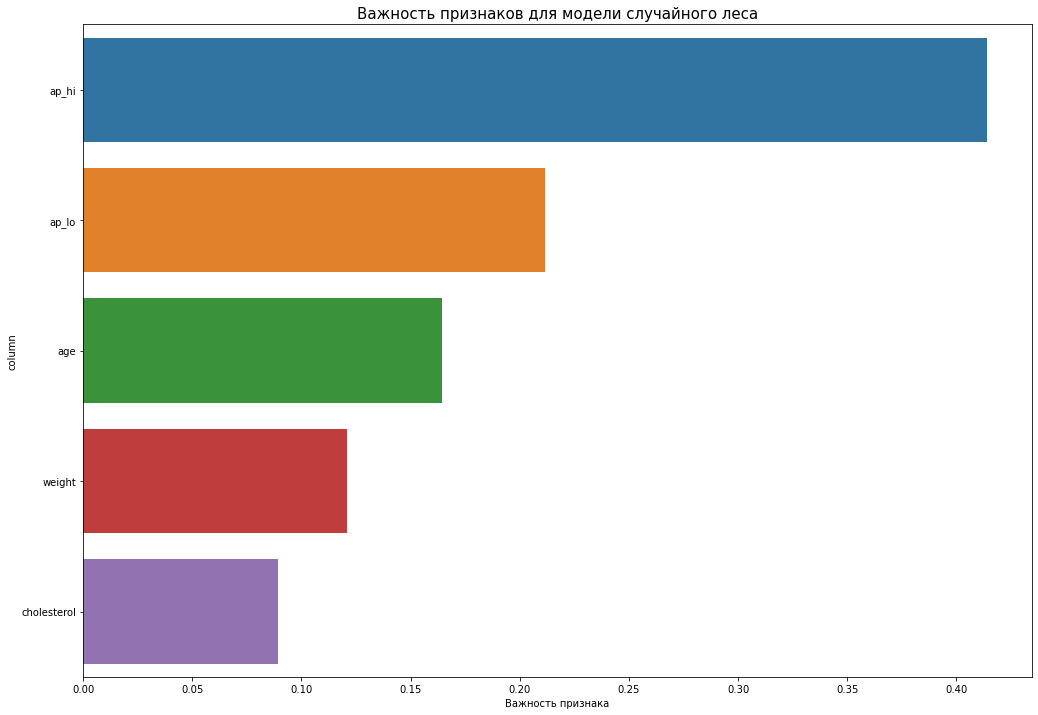

In [192]:
plt.figure(figsize=(17, 12))
sns.barplot(x='importance', y='column', data=importances)

plt.xlabel('Важность признака')
plt.title('Важность признаков для модели случайного леса', size=15)
plt.show()

**Вывод:** используем все отобранные признаки для построения модели.

<a name="subparagraph7"></a>

### 5.2 Подбор параметров

In [150]:
grid_params_dtc = [{'dtc__max_depth': range (6, 20, 2),
              'dtc__min_samples_leaf': range (2,8),
              'dtc__n_estimators': range (50, 351, 50)
              }]
 
model = RandomForestClassifier()

pipeline = Pipeline([('scaler',StandardScaler()), ('dtc', model)])
grid_dtc = GridSearchCV(estimator=pipeline,  
                    param_grid=grid_params_dtc,
                    scoring='roc_auc',
                    cv=5)

grid_dtc.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
grid_dtc.best_params_

In [ ]:
grid_dtc.best_score_

Построим модель по лучшим параметрам:

In [194]:
model_best = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=300, criterion='entropy', max_depth=10,\
                                          min_samples_leaf=7)
pipeline_best = make_pipeline(StandardScaler(), model_best)
pipeline_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=7, n_estimators=300,
                                        random_state=25))])

<a name="paragraph6"></a>

##  6. Предсказание вероятностей

Получим предсказания вероятностей сердечно-сосудистых заболеваний по лучшей модели:

In [195]:
proba_valid = pipeline_best.predict_proba(X_valid)[:, 1]

<a name="subparagraph8"></a>

### 6.1 Калибровка вероятностей

Перед сохранением результатов, откалибруем вероятности с помощью модели по алгоритму логистической регрессии:

In [196]:
lg = LogisticRegression().fit(proba_valid.reshape(-1, 1), y_valid)
proba_test_rfc_lg = lg.predict_proba(pipeline_best.predict_proba(X_test)[:, 1].reshape(-1, 1))[:, 1]

<a name="subparagraph9"></a>

### 6.2 Сохранение результатов

In [197]:
output_lg = pd.DataFrame({'id': df_test.id, 'cardio': proba_test_rfc_lg})
output_lg.head()

,id,cardio
0,5,0.455387
1,6,0.579920
2,7,0.368786
3,10,0.598672
4,11,0.213135


In [198]:
output_lg.to_csv('D:/DS+/Kaggle/submission_calibration_lg.csv', index=False)
print('Файл сохранен!')

Файл сохранен!
